# Trade Algorithm to Automate Short Position Trades Using Daily Patterns


Only allowed short positions (selling first, buying later)


Max. stop loss 7% of initial investment


Max. take profit 14%-21% of initial investment (2:1/3:1 risk-reward ratio depending on leverage)


Support and Resistance levels calculated using anticipated pct. change in price over last 5 days

In [73]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests
import datetime
import hashlib
from difflib import get_close_matches
import hmac
import base64
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2, l1, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import urllib.parse

# Import config file
import sys
sys.path.insert(0, '../')
import config as cfg

In [74]:
api_key = cfg.api_key
private_key = cfg.api_priv

## API Fetchin

In [75]:
api_url = "https://api.kraken.com"

# Create dictionary to map API endpoints to their respective names and respective request types
api_endpoints = {
    'Assets': '/0/public/Assets',
    'AssetPairs': '/0/public/AssetPairs',
    'Ticker': '/0/public/Ticker',
    'OHLC': '/0/public/OHLC',
    'default OHLC': '/0/public/OHLC',

    'Balance': '/0/private/Balance',
    'ExtendedBalance': '/0/private/BalanceEx',
    'Ledgers': '/0/private/Ledgers',
    'QueryLedgers': '/0/private/QueryLedgers',
    'TradeVolume': '/0/private/TradeVolume',
    'TradesHistory': '/0/private/TradesHistory',
    'OpenOrders': '/0/private/OpenOrders',

}

# Function to generate a nonce
def generate_nonce():
    nonce = str(int(1000 * time.time()))
    return nonce

# Function to get Kraken signature
def get_kraken_signature(urlpath, data, secret):
    postdata = urllib.parse.urlencode(data)
    encoded = (str(data['nonce']) + postdata).encode()
    message = urlpath.encode() + hashlib.sha256(encoded).digest()

    mac = hmac.new(base64.b64decode(secret), message, hashlib.sha512)
    sigdigest = base64.b64encode(mac.digest())
    return sigdigest.decode() 

# Function to make Kraken API request
def kraken_request(uri_path, data, api_key, api_sec, headers=None):
    if headers is None:
        headers = {}

    headers['API-Key'] = api_key
    headers['API-Sign'] = get_kraken_signature(uri_path, data, api_sec)
    req = requests.post((api_url + uri_path), headers=headers, data=data)
    return req

#Function to make more non-trivial Kraken API get request
def kraken_get_request(uri_path, data=None, headers=None):
    if uri_path != api_endpoints['OHLC']:
        if headers is None:
            headers = {
                'Accept': 'application/json'
            }
        
        headers.update(headers)
        req = requests.get((api_url + uri_path), headers=headers, data=data)
    elif uri_path == api_endpoints['OHLC']:
        temp_endpoint = api_endpoints['OHLC'] + '?pair=' + data['pair'] + '&interval=' + data['interval']
        req = requests.get((api_url + temp_endpoint), headers=headers)
    return req


In [76]:
# Possible intervals: 1, 5, 15, 30, 60, 240, 1440, 10080, 21600 in minutes i.e., 1 minute, 5 minutes, 15 minutes, 30 minutes, 1 hour, 4 hours, 1 day, 1 week, 1 month
# Possible tenures: 1D (1440), 7D (10080), 1M (43200), 3M (129600), 6M (259200), 1Y (518400) - corresponding intervals are tenure/720 to maximize data points from a single request
possible_intervals =[1, 5, 15, 30, 60, 240, 1440, 10080, 21600]
possible_timeframes = {'1D': 1440, '7D': 10080, '1M': 43200, '3M': 129600, '6M' : 259200, '1Y': 518400}

tenure = '1Y'


In [77]:
# 1. Get Historical OHLC Data of the Asset(s) using Kraken REST API
# Function to grab the OHLC data for a given list of asset pairs
def grab_ohlc_data(assetPairs,tenure):
    # divide timerframe by 720 to get the interval but use the next larger closet possible interval
    interval = min([i for i in possible_intervals if i >= possible_timeframes[tenure]/720], default=possible_intervals[-1])
    interval = str(interval)
    # Construct since parameter for the OHLC request using tenure and datetime unix converted timestamp, i.e., subtracting the tenure from the current time and equating it to the since parameter
    since = int(time.time()) - possible_timeframes[tenure]*60
    since = str(since)

    # Construct the Kraken API request and get the OHLC data for the given asset pairs, ohlc grabbing requires use of a temporary endpoint for the OHLC url
    ohlcDict = {}
    for assetPair in assetPairs:
        resp = kraken_get_request(api_endpoints['OHLC'], {"pair": assetPair, "interval": interval, "since": since}).json()
        if resp['error'] == KeyError:
            #skip this asset pair
            continue
        ohlcDict[assetPair] = list(resp['result'].values())
        # To process the response, we need to extract the OHLC data from the response particularly the tick data array and the last timestamp
    # Append the OHLC data to a dataframe and return the dataframe with columns: Time, Open, High, Low, Close, Volume, Count, name it after the asset pair
    return ohlcDict


# 2. Calculate Entry and Exit Points
# 2.1 Calculate anticipated percentage change in price using Linear Regression or Neural Networks
def calculate_anticipated_pct_change(data, method='NN'):
    if method == 'LR':
        # Using Linear Regression to Predict Percentage Change
        model = LinearRegression()
        data['Days'] = range(len(data))  # Add a column representing the number of days for fitting
        X = data[['Days']]
        y = data['Close']
        model.fit(X, y) 
        predicted_price = model.predict([[len(data)]])[0]  # Predicting the next value
        anticipated_pct_change = ((predicted_price - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100
    else:    
        # Alternatively, using a simple Neural Network with TensorFlow
        # Prepare data for Neural Network
        features = np.array(data[['Days']])
        target = np.array(data['Close'])
        model_nn = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
            tf.keras.layers.Dense(1)
        ])
        model_nn.compile(optimizer='adam', loss='mse')
        model_nn.fit(features, target, epochs=100, verbose=0)
        predicted_price_nn = model_nn.predict([[len(data)]])[0][0]
        anticipated_pct_change_nn = ((predicted_price_nn - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

        # Combining the results from Linear Regression and Neural Network for better estimation
        anticipated_pct_change = (anticipated_pct_change + anticipated_pct_change_nn) / 2
    return anticipated_pct_change

# 2.2 Calculate support and resistance levels
def calculate_support_resistance(data, anticipated_pct_change):
    current_price = data['Close'].iloc[-1]
    resistance_level = current_price * (1 + anticipated_pct_change / 100)
    support_level = current_price * (1 - anticipated_pct_change / 100)
    return support_level, resistance_level

# 3. Risk Management
# 3.1 Calculate stop loss and take profit levels based on desired risk-reward ratio
def calculate_risk_management_levels(entry_price, risk_reward_ratio):
    stop_loss = entry_price * (1 - 0.07)  # Max stop loss 7%
    take_profit = entry_price * (1 + (risk_reward_ratio * 0.07))  # Take profit based on risk-reward ratio
    return stop_loss, take_profit

# 3.2 Calculate position size
def calculate_position_size(total_capital, entry_price, stop_loss):
    risk_per_trade = total_capital * 0.02  # Assume 2% risk of total capital per trade
    position_size = risk_per_trade / abs(entry_price - stop_loss)
    return position_size

# 4. Execute Trade Using Kraken REST API
def execute_trade(api_key, private_key, asset_symbol, position_size, entry_price, order_type="sell"):
    api_url = "https://api.kraken.com/0/private/AddOrder"
    nonce = str(int(time.time() * 1000))
    
    # Data payload for the trade
    data = {
        "nonce": nonce,
        "ordertype": "limit",
        "type": order_type,  # "sell" for short positions
        "volume": position_size,
        "pair": asset_symbol,
        "price": entry_price,
        "leverage": "2:1"  # Example leverage, can be adjusted
    }
    
    # Create the Kraken API signature
    postdata = urllib.parse.urlencode(data)
    message = (nonce + postdata).encode()
    sha256 = hashlib.sha256(nonce.encode() + postdata.encode()).digest()
    hmac_key = base64.b64decode(private_key)
    signature = hmac.new(hmac_key, b"/0/private/AddOrder" + sha256, hashlib.sha512)
    signature_b64 = base64.b64encode(signature.digest())
    
    headers = {
        "API-Key": api_key,
        "API-Sign": signature_b64.decode()
    }
    
    response = requests.post(api_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Failed to execute trade: " + response.text)


In [78]:
assetList = ['XXRP','SOL', 'XXBT', 'TIA', 'TAO', 'OP','FLR','AXS','APT','MSOL']

## 1. Get historical data of the asset(s)
1.1. Verify data quality and check for missing values/outliers.


1.2. Account for trading volumes, volatility, and any specific asset-related adjustments.


1.3. Pull leverage-related information.


1.4. Calculate 9 and 21 day MAs & EMAs and determine trade signals, position to be taken, and calculate expected returns based on signals obtained at crossover points.

In [79]:
allAssetPairs = kraken_get_request(api_endpoints['AssetPairs'], headers={'country_code':'GB'}).json()['result']

# Filter the asset pairs based on the assetList and quote currency
# tradeablePairs = [
#     {key: asset[key] for key in ['altname','base', 'quote', 'ordermin', 'fees', 'fees_maker','leverage_buy', 'leverage_sell']}
#     for asset in allAssetPairs.values() if asset['quote'] == 'ZUSD'
# ]

tradeablePairs = [
    {key: asset[key] for key in ['altname','base', 'quote', 'ordermin', 'fees', 'fees_maker','leverage_buy', 'leverage_sell']}
    for asset in allAssetPairs.values() if asset['wsname'][-3:] == 'USD'
]


# Check if asset['base'] is in the assetList
filteredPairs = [asset for asset in tradeablePairs if asset['base'] in assetList]


# Get the OHLC data for the filtered asset pairs
#ohlcData = grab_ohlc_data([asset['base'] + asset['quote'] for asset in filteredPairs], tenure)
ohlcData = grab_ohlc_data([asset['altname'] for asset in filteredPairs], tenure)

# Create separate DataFrame for each asset
ohlcDFs = {}
for asset, rows in ohlcData.items():
    # Flatten rows and convert to DataFrame
    df = pd.DataFrame(rows[0], columns=["Time", "Open", "High", "Low", "Close", "VWAP", "Volume", "Count"])
    
    # Convert 'Time' to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Split to date and time
    df['Date'] = df['Time'].dt.date
    # df['Time'] = df['Time'].dt.time
    
    # Convert necessary columns to numeric
    df[['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']].apply(pd.to_numeric)
    
    # Convert Date to index
    #df.set_index("Date", inplace=True)
    
    # Calculate Moving Averages, 9 and 21 day
    df['9 day MA'] = df['Close'].rolling(window=9).mean().shift(1)#.shift(1) to avoid look-ahead bias
    df['21 day MA'] = df['Close'].rolling(window=21).mean().shift(1)#.shift(1) to avoid look-ahead bias
    df['200 day MA'] = df['Close'].rolling(window=200).mean().shift(1)#.shift(1) to avoid look-ahead bias
    df['9 day EMA'] = df['Close'].ewm(span=9, adjust=False).mean()
    df['21 day EMA'] = df['Close'].ewm(span=21, adjust=False).mean()
    df['200 day EMA'] = df['Close'].ewm(span=200, adjust=False).mean()
    
    # Store DataFrame in a dictionary with asset name
    ohlcDFs[asset] = df

ohlcDFs.pop('XBTPYUSD')

# Calculate signals based on Moving Average Differences, add to new columns, 1 if 9 day MA > 21 day MA, -1 if 9 day MA < 21 day MA, 0 otherwise, Singla MA and Signal EMA
# Add instantaneous return/system return column
for asset, df in ohlcDFs.items():
    df['Signal MA'] = np.where(df['9 day MA'] > df['21 day MA'], 1, np.where(df['9 day MA'] < df['21 day MA'], -1, 0))
    df['Signal EMA'] = np.where(df['9 day EMA'] > df['21 day EMA'], 1, np.where(df['9 day EMA'] < df['21 day EMA'], -1, 0))
    df['Return'] = np.log(df['Close']).diff()#.pct_change()
    df['System Return MA'] = df['Signal MA'] * df['Return']
    df['System Return EMA'] = df['Signal EMA'] * df['Return']
    df['Signal'] = 0
    df['Signal'] = np.where(df['9 day EMA'] > df['21 day EMA'], 1, 0)
    df['Signal'] = np.where(df['9 day EMA'] < df['21 day EMA'], -1, df['Signal'])
    df['Position'] = df['Signal'].diff()
    df.dropna(inplace=True) # Drop rows with NaN values, shifted rows before 21 days MA calculation

# for key, value in ohlcData.items():
#     if key == 'TAOUSD':
#         print(f"{key}: {value[0]}")
#     if value == []:
#         print(f"{key}: {value}")


In [81]:
print(ohlcDFs['TAOUSD'])

Empty DataFrame
Columns: [Time, Open, High, Low, Close, VWAP, Volume, Count, Date, 9 day MA, 21 day MA, 200 day MA, 9 day EMA, 21 day EMA, 200 day EMA, Signal MA, Signal EMA, Return, System Return MA, System Return EMA, Signal, Position]
Index: []

[0 rows x 22 columns]


In [82]:
# Calculate Bitcoin Correlation Factors (BCFs) for all assets
# Calculate the correlation between price movements of each asset against Bitcoin (XBTUSD)
bcfs = {}
for asset, df in ohlcDFs.items():
    # Calculate the correlation between the asset and Bitcoin
    correlation = df['Return'].corr(ohlcDFs['MSOLUSD']['Return'])
    bcfs[asset] = correlation

# Sort the assets based on their correlation with Bitcoin
sorted_bcfs = dict(sorted(bcfs.items(), key=lambda x: x[1], reverse=True))

# Print the sorted Bitcoin Correlation Factors - BCFs, using msol for now because it is more volatile, better tracking for short term
print("Marinade Solana Correlation Factors (MCFs):")
for asset, correlation in sorted_bcfs.items():
    print(f"{asset}: {correlation:.2f}")

Marinade Solana Correlation Factors (MCFs):
MSOLUSD: 1.00
SOLUSD: 0.96
TAOUSD: nan
XBTUSD: 0.65
AXSUSD: 0.59
APTUSD: 0.53
XRPUSD: 0.39
TIAUSD: 0.09
OPUSD: 0.04
FLRUSD: -0.07


In [83]:
# Debug Prints
# show 9thto 25th row of first df
#ohlcDFs['XRPUSD'].iloc[0:25]

# Show first instance where position is non zero
#ohlcDFs['TAOUSD'][ohlcDFs['TAOUSD']['Position'] != 0].head(2)
# index = df.index
# print(index)

1.5 Plot MA Crossover strat using green and red up and down arrows signifying long and short signals respectively.

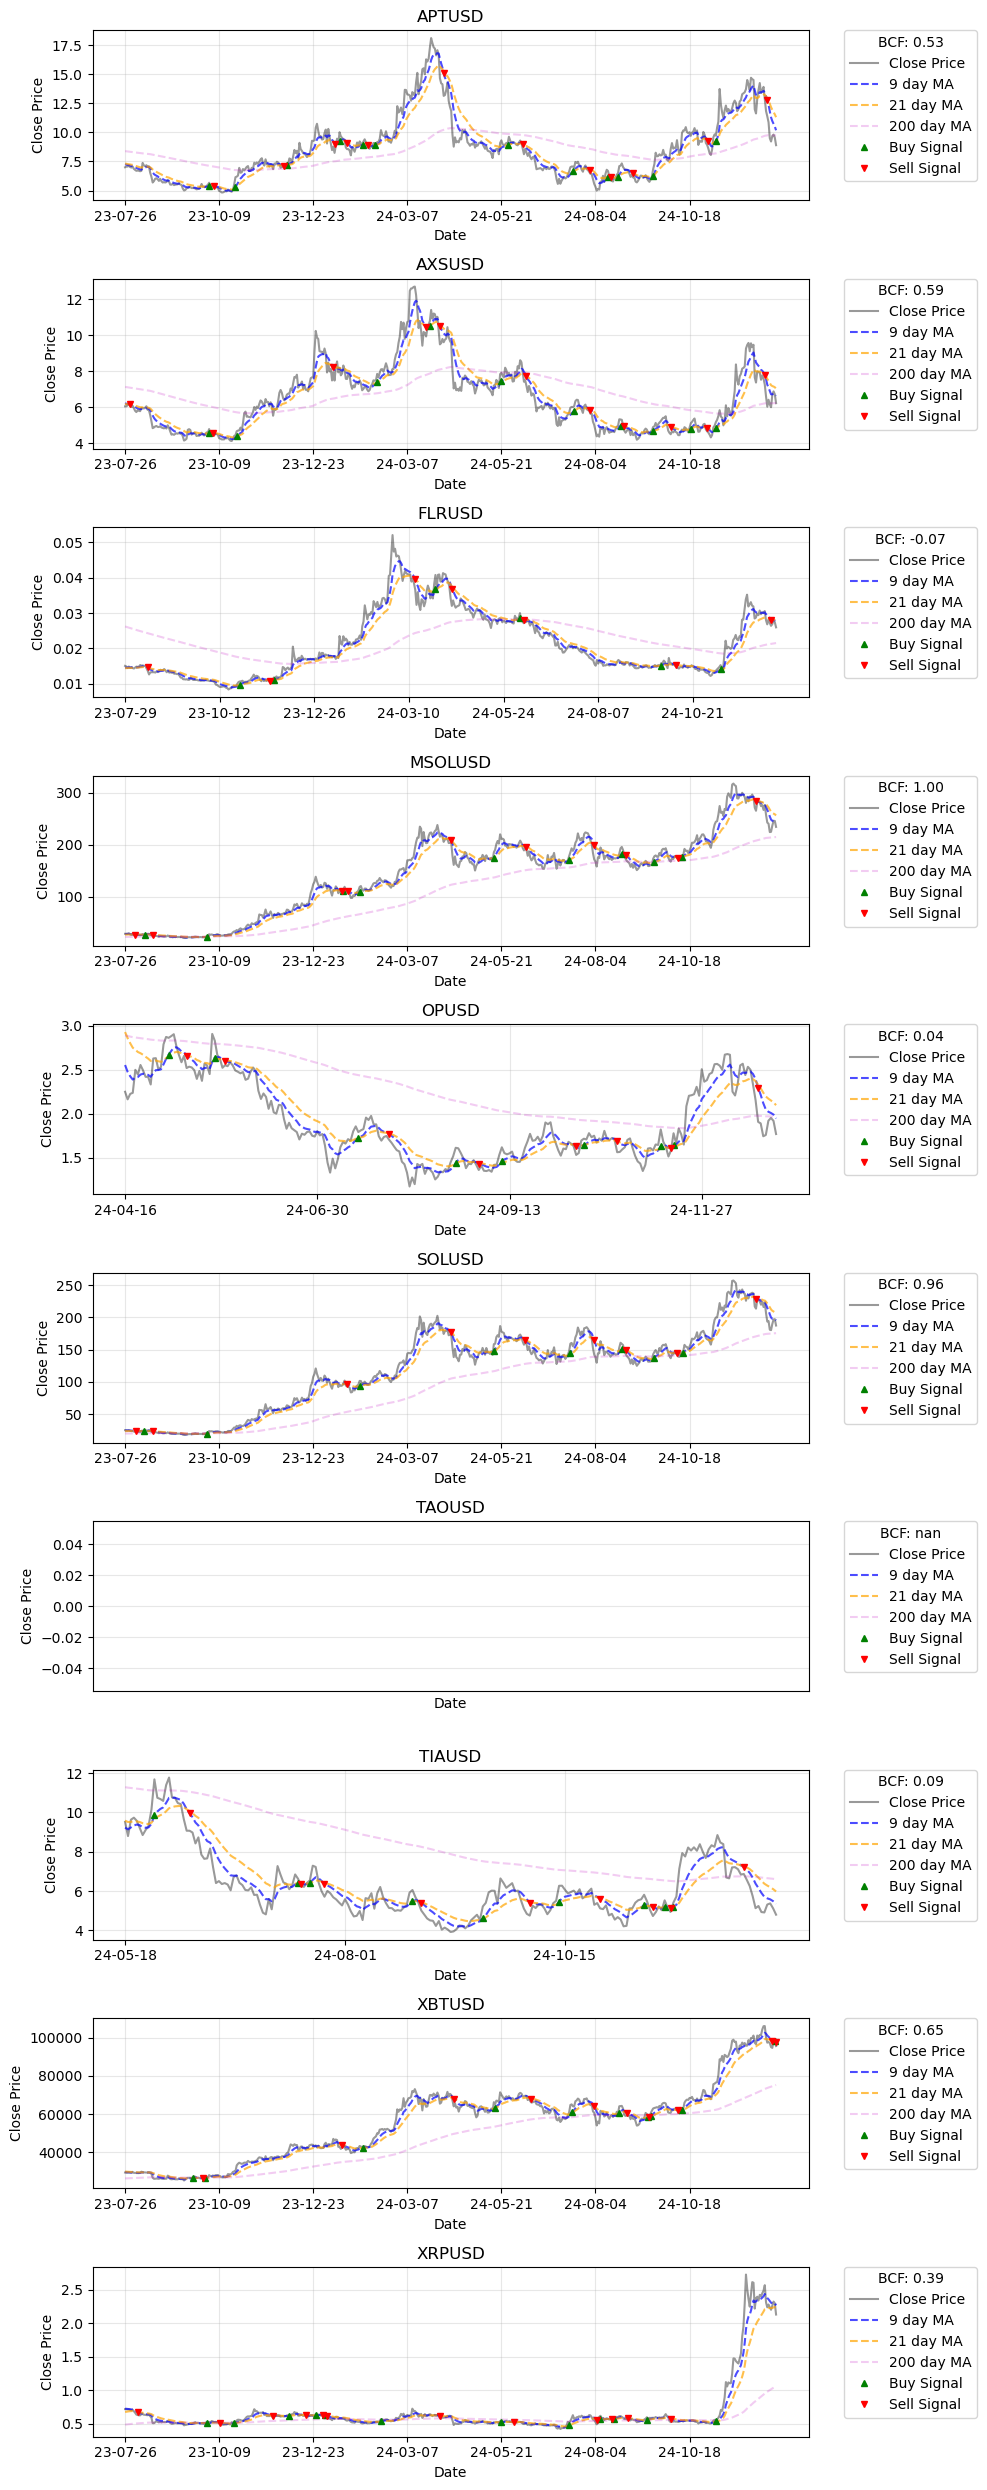

In [84]:
# Plot Closing Prices for all assets on separate subplots
# Plot 9 and 21 day Moving Averages
# Plot Buy and Sell Signals
# Plot System Returns for Moving Average and Exponential Moving Average Strategies on the right of the price plot
# Plot the anticipated percentage change in price as a horizontal line on the price plot

fig, axes = plt.subplots(nrows=len(ohlcDFs), ncols=1, figsize=(10,25))

for i, (asset, df) in enumerate(ohlcDFs.items()): #  df.index[::30]
    df['Close'].plot(ax=axes[i], title=asset, color='k', label='Close Price', alpha=0.4)
    
    df['9 day EMA'].plot(ax=axes[i], color='b', linestyle='--', label='9 day MA', alpha=0.7)
    df['21 day EMA'].plot(ax=axes[i], color='orange', linestyle='--', label='21 day MA', alpha=0.7)
    df['200 day EMA'].plot(ax=axes[i], color='m', linestyle='--', label='200 day MA', alpha=0.2)
    axes[i].plot(df[-711:].loc[df['Position'] == 2].index, df[-711:]['9 day EMA'][df['Position'] == 2], '^', color='g', markersize=5, label='Buy Signal')
    axes[i].plot(df[-711:].loc[df['Position'] == -2].index, df[-711:]['9 day EMA'][df['Position'] == -2], 'v', color='r', markersize=5, label='Sell Signal')
    axes[i].set_ylabel('Close Price')
    axes[i].set_xlabel('Date')
    axes[i].set_xticks(df.iloc[::75]['Time'].index) # take the date every 112 rows, 4 x 28 day trading cycles
    axes[i].set_xticklabels(df.iloc[::75]['Time'].dt.strftime('%y-%m-%d'))#, rotation=45)          #df["Date"][::len(df)//10]
    axes[i].grid(alpha=0.3)
    # Add correlations BCFs to legend and position the legend outside the plot
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = f'BCF: {sorted_bcfs[asset]:.2f}')
plt.tight_layout()

# Hide userwarnings
import warnings
warnings.filterwarnings('ignore')

In [85]:
# For an example, use windowing to reduce the ohlc data by averaging every 10 rows
#ohlcDFs['XRPUSD'] = ohlcDFs['XRPUSD'].iloc[::10].copy()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


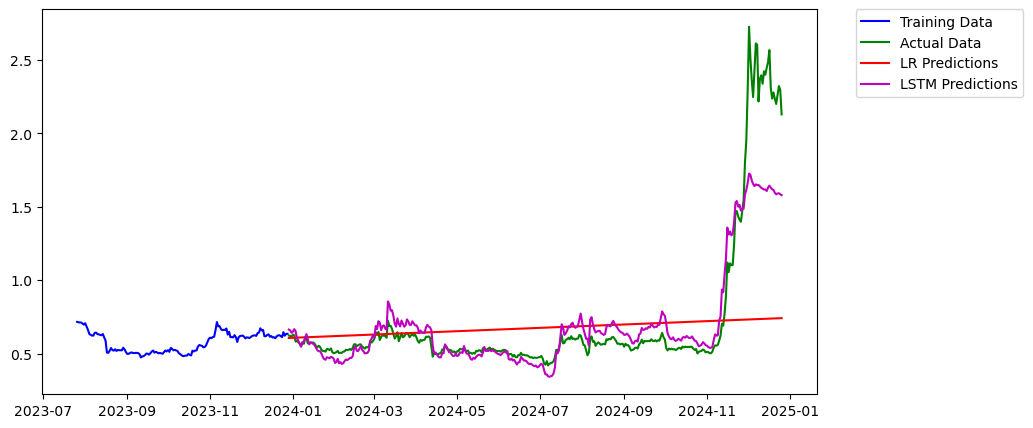

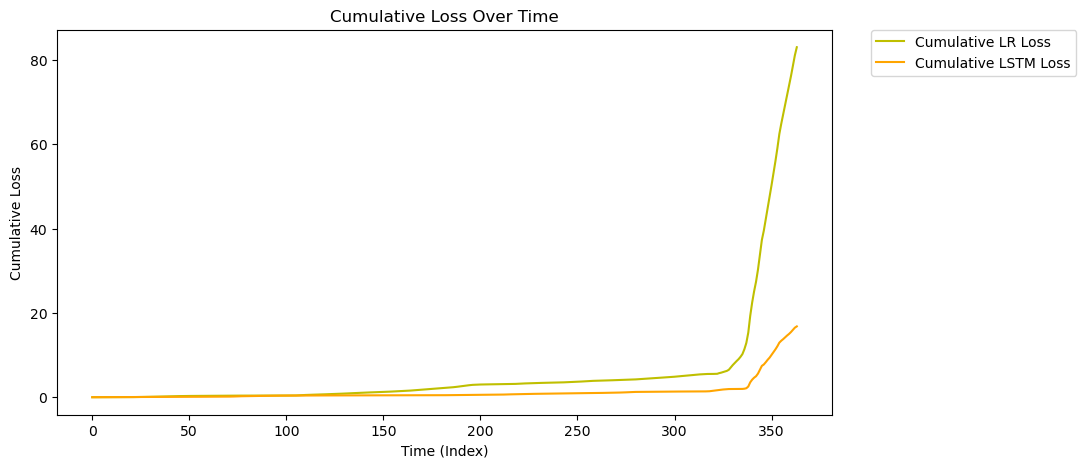

In [86]:
# Extract data for the past day for asset in the list
data_fit = ohlcDFs['XRPUSD'][:round(0.3*len(ohlcDFs['XRPUSD']))]
data_predict = ohlcDFs['XRPUSD'][round(0.3*len(ohlcDFs['XRPUSD'])):]

# Add a column representing the number of days for fitting
data_fit['Days'] = (data_fit['Time'] - data_fit['Time'].min()).dt.days
data_predict['Days'] = (data_predict['Time'] - data_fit['Time'].min()).dt.days
# Debug Prints
#print(data_fit['Time'].head(5))

## Linear Regression Predictions
# Using Linear Regression to Predict Percentage Change
model = LinearRegression()
X = data_fit[['Days']]
y = data_fit['Close']
model.fit(X, y) 

lr_predictions = model.predict(data_predict[['Days']])
## Neural Network Predictions
# Prepare data for Neural Network, 8 features and 1 target
features = np.array(data_fit[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count', '9 day EMA', '21 day EMA']])
target = np.array(data_fit['Close'])
# Prepare data for LSTM Neural Network

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Reshape the data for LSTM (samples, time steps, features)
X_train = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# Define the LSTM model, with dropout and regularization to reduce overfitting
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(21, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                         kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(21, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm.fit(X_train, target, epochs=2500, validation_split=0.2, callbacks=[early_stopping], verbose=0)


# Prepare the prediction data
scaled_data_predict = scaler.transform(np.array(data_predict[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count', '9 day EMA', '21 day EMA']]))
X_test = scaled_data_predict.reshape((scaled_data_predict.shape[0], 1, scaled_data_predict.shape[1]))

# Make predictions
lstm_predictions = model_lstm.predict(X_test)[:, 0]

# Calculate cummulative l2 loss
# Calculate cumulative L2 loss for each prediction up to the final value
cumulative_lr_loss = np.cumsum(np.square(data_predict['Close'] - lr_predictions))
cumulative_lstm_loss = np.cumsum(np.square(data_predict['Close'] - lstm_predictions))

# Combine the cumulative losses into a list of tuples
cumulative_errors = list(zip(cumulative_lr_loss, cumulative_lstm_loss))

# model_nn.compile(optimizer='adam', loss='mse')
# model_nn.fit(features, target, epochs=2500, verbose=0)
#nn_predictions = model_nn.predict(np.array(data_predict[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']]))[:, 0]

## Plotting
# Plot the data used to train the model, the model itself, and the forecasted data
# Then on the same plot add bar charts showing the loss for each model
plt.figure(figsize=(10,5))
plt.plot(data_fit['Time'], data_fit['Close'], label='Training Data', color='b')
plt.plot(data_predict['Time'], data_predict['Close'], label='Actual Data', color='g')
plt.plot(data_predict['Time'], lr_predictions, label='LR Predictions', color='r')
plt.plot(data_predict['Time'], lstm_predictions, label='LSTM Predictions', color='m')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_lr_loss)), cumulative_lr_loss, label='Cumulative LR Loss', color='y')
plt.plot(range(len(cumulative_lstm_loss)), cumulative_lstm_loss, label='Cumulative LSTM Loss', color='orange')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Plot bar charts showing loss, linear regression and neural network in yellow and orange respectively
#plt.bar(['Linear Regression', 'Neural Network'], [lr_loss, lstm_loss], color=['y', 'orange'])



# predicted_price = model.predict([[len(data)]])[0]  # Predicting the next value
# anticipated_pct_change = ((predicted_price - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

# anticipated_pct_change_nn = ((predicted_price_nn - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

# # Combining the results from Linear Regression and Neural Network for better estimation
# anticipated_pct_change = (anticipated_pct_change + anticipated_pct_change_nn) / 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


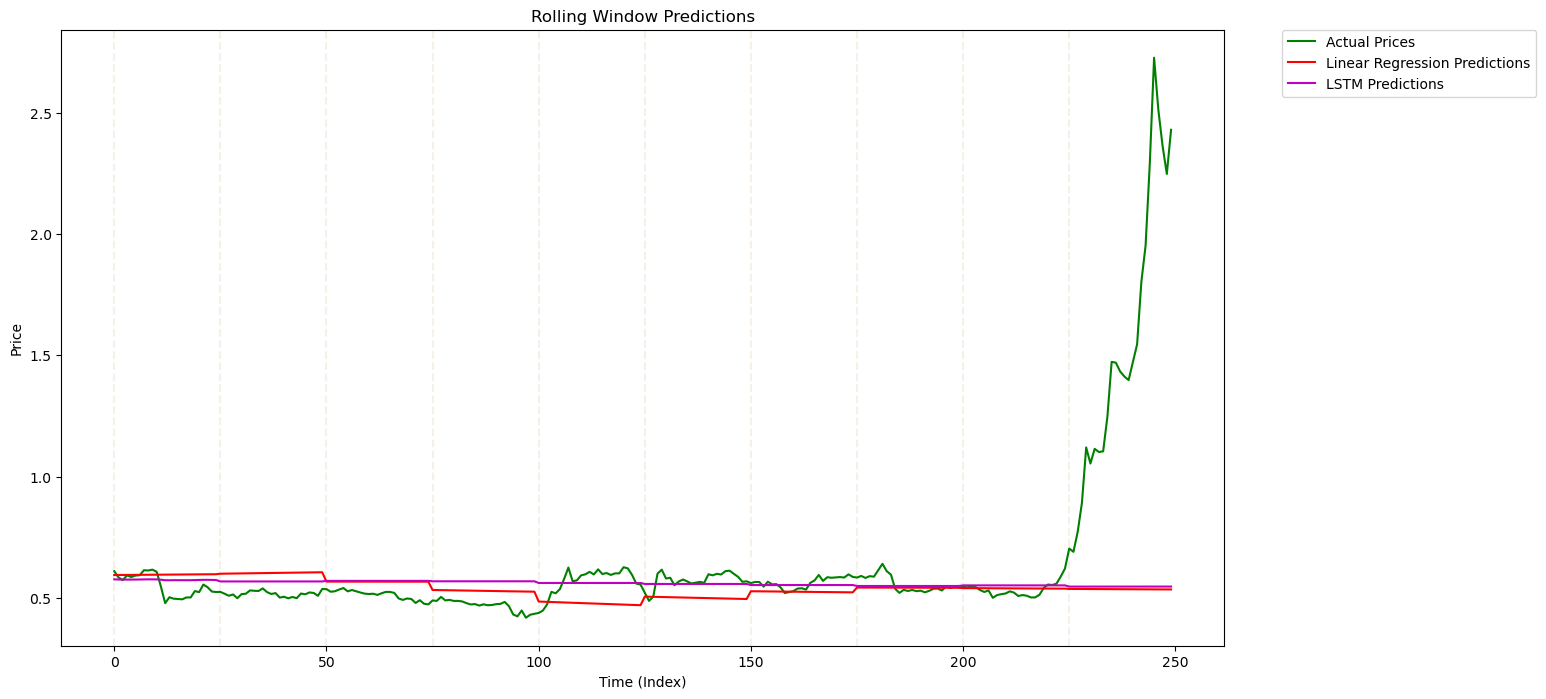

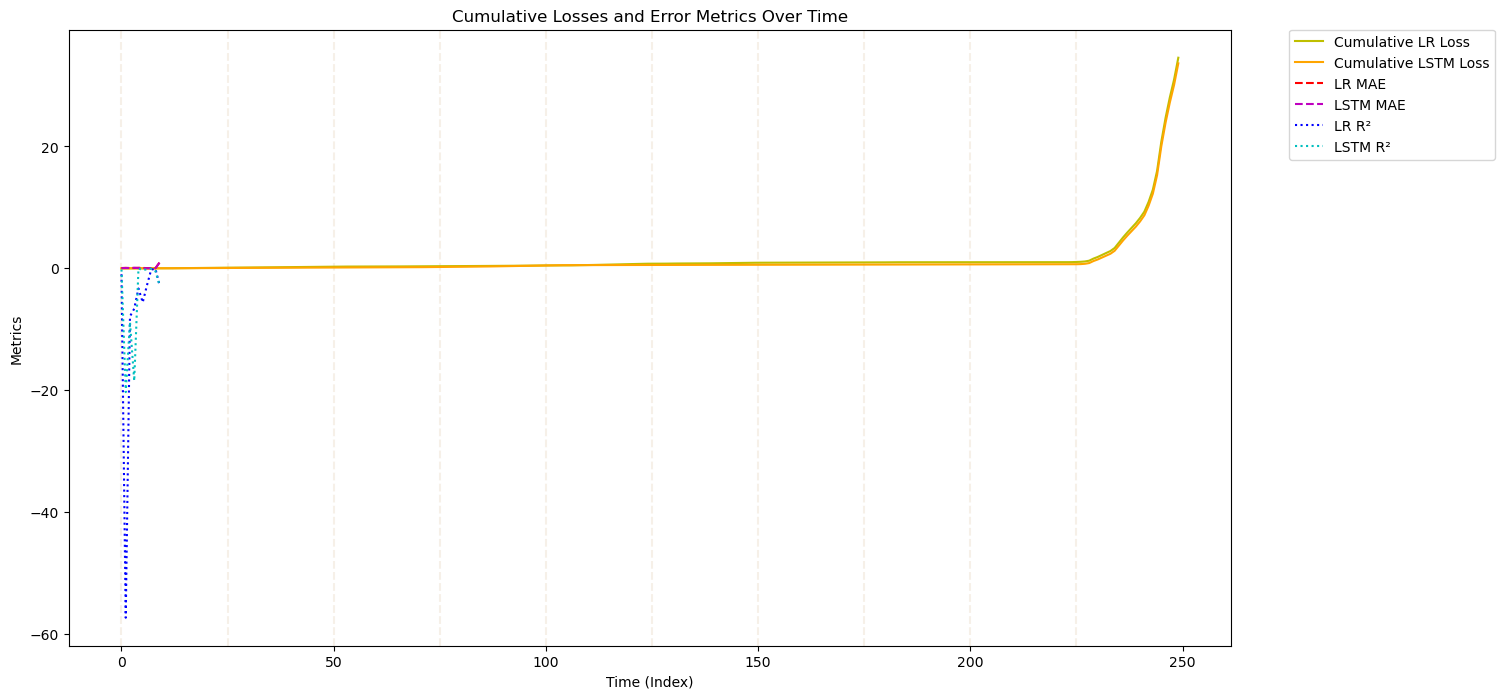

In [90]:
# Parameters
window_size = 250  # Size of the rolling window (number of days)
prediction_size = 5  # Number of steps to predict
epochs = 100  # Number of training epochs per window
batch_size = 50  # Batch size for LSTM training

# window_size = 500  # Size of the rolling window (number of days)
# prediction_size = 25  # Number of steps to predict
# epochs = 100  # Number of training epochs per window
# batch_size = 50  # Batch size for LSTM training


# Extract data
data = ohlcDFs['XRPUSD']
data['Days'] = (data['Time'] - data['Time'].min()).dt.days
data['Time'].dt.strftime('%y-%m-%d')
#data.plot(y='Close', title='Close Price Over Time', xlabel='Days', ylabel='Price', figsize=(15, 8))

# Initialize lists to store predictions, losses, and metrics
lr_predictions = []
lstm_predictions = []
actuals = []
window_points = []
rolling_mae_lr = []
rolling_mae_lstm = []
rolling_r2_lr = []
rolling_r2_lstm = []

# Scaler for features
scaler = MinMaxScaler()

# Define the LSTM model with regularization
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(30, return_sequences=True, input_shape=input_shape,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout = 0.2, recurrent_dropout = 0.2),
        tf.keras.layers.LSTM(30, kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout = 0.2, recurrent_dropout = 0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create a single LSTM model
input_shape = (1, len(['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']))
lstm_model = create_lstm_model(input_shape)

# Rolling window loop with batch training
for start_idx in range(0, len(data) - window_size - prediction_size, prediction_size):
    # Define the rolling window
    train_window = data.iloc[start_idx: start_idx + window_size]
    predict_window = data.iloc[start_idx + window_size: start_idx + window_size + prediction_size]

    # Add adjusted window start to the list
    window_points.append(len(actuals))  # Adjusted to match the cumulative index range

    # Scale the features
    features = ['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']
    scaled_features = scaler.fit_transform(train_window[features])
    target = train_window['Close'].values

    # Reshape for LSTM
    X_train = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

    # Prepare data for prediction
    scaled_predict_features = scaler.transform(predict_window[features])
    X_predict = scaled_predict_features.reshape((scaled_predict_features.shape[0], 1, scaled_predict_features.shape[1]))

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(train_window[['Days']], train_window['Close'])
    lr_prediction = lr_model.predict(predict_window[['Days']])
    lr_predictions.extend(lr_prediction)

    # Train LSTM
    lstm_model.fit(X_train, target, epochs=epochs, batch_size=batch_size, verbose=0)

    # Make LSTM predictions
    lstm_prediction = lstm_model.predict(X_predict)[:, 0]
    lstm_predictions.extend(lstm_prediction)

    # Store actual values
    actuals.extend(predict_window['Close'].values)

    # Calculate error metrics for the current window
    mae_lr = mean_absolute_error(predict_window['Close'], lr_prediction)
    mae_lstm = mean_absolute_error(predict_window['Close'], lstm_prediction)
    r2_lr = r2_score(predict_window['Close'], lr_prediction)
    r2_lstm = r2_score(predict_window['Close'], lstm_prediction)

    rolling_mae_lr.append(mae_lr)
    rolling_mae_lstm.append(mae_lstm)
    rolling_r2_lr.append(r2_lr)
    rolling_r2_lstm.append(r2_lstm)

# Calculate cumulative losses
cumulative_lr_loss = np.cumsum(np.square(np.array(actuals) - np.array(lr_predictions)))
cumulative_lstm_loss = np.cumsum(np.square(np.array(actuals) - np.array(lstm_predictions)))

# Plotting results
plt.figure(figsize=(15, 8))
plt.plot(range(len(actuals)), actuals, label='Actual Prices', color='g', zorder=5)
plt.plot(range(len(lr_predictions)), lr_predictions, label='Linear Regression Predictions', color='r', zorder=5)
plt.plot(range(len(lstm_predictions)), lstm_predictions, label='LSTM Predictions', color='m', zorder=5)

# Add vertical dashed lines for each window start
for window_point in window_points:
    plt.axvline(x=window_point, color='tan', linestyle='--', alpha=0.2, zorder=0)

# Add markers
# plt.scatter(range(len(lr_predictions)), lr_predictions, color='r', s=10, label='LR Markers', alpha=0.6)
# plt.scatter(range(len(lstm_predictions)), lstm_predictions, color='m', s=10, label='LSTM Markers', alpha=0.6)

plt.xlabel('Time (Index)')
plt.ylabel('Price')
plt.title('Rolling Window Predictions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Loss visualization with cumulative losses and error metrics
plt.figure(figsize=(15, 8))
plt.plot(range(len(cumulative_lr_loss)), cumulative_lr_loss, label='Cumulative LR Loss', color='y')
plt.plot(range(len(cumulative_lstm_loss)), cumulative_lstm_loss, label='Cumulative LSTM Loss', color='orange')
plt.plot(range(len(rolling_mae_lr)), rolling_mae_lr, label='LR MAE', linestyle='--', color='r')
plt.plot(range(len(rolling_mae_lstm)), rolling_mae_lstm, label='LSTM MAE', linestyle='--', color='m')
plt.plot(range(len(rolling_r2_lr)), rolling_r2_lr, label='LR R²', linestyle=':', color='b')
plt.plot(range(len(rolling_r2_lstm)), rolling_r2_lstm, label='LSTM R²', linestyle=':', color='c')

# Add vertical dashed lines for each window start
for window_point in window_points:
    plt.axvline(x=window_point, color='tan', linestyle='--', alpha=0.2, zorder=0)

plt.xlabel('Time (Index)')
plt.ylabel('Metrics')
plt.title('Cumulative Losses and Error Metrics Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [132]:
cumulative_lstm_loss[-1]
cumulative_lr_loss[-1]

np.float64(0.773966884561837)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


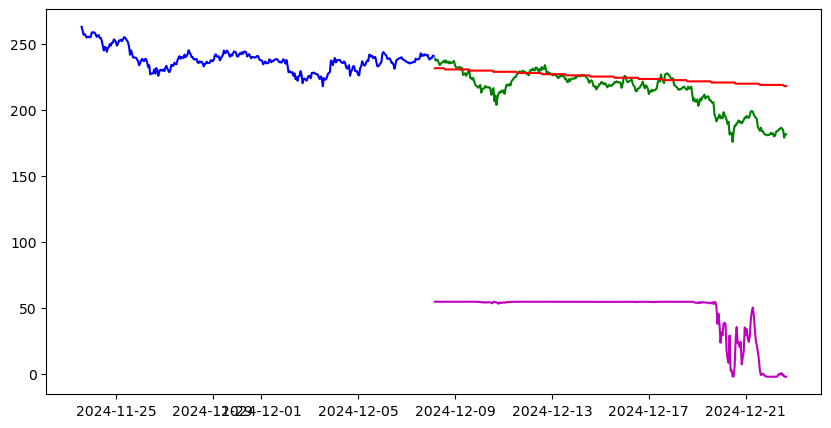

In [109]:
# Extract data for the past day for asset in the list
data_fit = ohlcDFs['SOLUSD'][:round(len(ohlcDFs['SOLUSD'])/2)]
data_predict = ohlcDFs['SOLUSD'][round(len(ohlcDFs['SOLUSD'])/2):]
# Add a column representing the number of days for fitting
data_fit['Days'] = (data_fit['Time'] - data_fit['Time'].min()).dt.days
data_predict['Days'] = (data_predict['Time'] - data_fit['Time'].min()).dt.days
# Debug Prints
#print(data_fit['Time'].head(5))

## Linear Regression Predictions
# Using Linear Regression to Predict Percentage Change
model = LinearRegression()
X = data_fit[['Days']]
y = data_fit['Close']
model.fit(X, y) 

lr_predictions = model.predict(data_predict[['Days']])
## Neural Network Predictions
# Prepare data for Neural Network, 8 features and 1 target
features = np.array(data_fit[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']])
target = np.array(data_fit['Close'])
# Prepare data for LSTM Neural Network

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Reshape the data for LSTM (samples, time steps, features)
X_train = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# Define the LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, target, epochs=100, verbose=0)

# Prepare the prediction data
scaled_data_predict = scaler.transform(np.array(data_predict[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']]))
X_test = scaled_data_predict.reshape((scaled_data_predict.shape[0], 1, scaled_data_predict.shape[1]))

# Make predictions
lstm_predictions = model_lstm.predict(X_test)[:, 0]

# Unscale the predictions
#lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))[:, 0]

# model_nn.compile(optimizer='adam', loss='mse')
# model_nn.fit(features, target, epochs=2500, verbose=0)
#nn_predictions = model_nn.predict(np.array(data_predict[['Days', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Count']]))[:, 0]

## Plotting
# Plot the data used to train the model, the model itself, and the forecasted data
plt.figure(figsize=(10,5))
plt.plot(data_fit['Time'], data_fit['Close'], label='Training Data', color='b')
plt.plot(data_predict['Time'], data_predict['Close'], label='Actual Data', color='g')
plt.plot(data_predict['Time'], lr_predictions, label='LR Predictions', color='r')
plt.plot(data_predict['Time'], lstm_predictions, label='NN Predictions', color='m')


# predicted_price = model.predict([[len(data)]])[0]  # Predicting the next value
# anticipated_pct_change = ((predicted_price - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

# anticipated_pct_change_nn = ((predicted_price_nn - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

# # Combining the results from Linear Regression and Neural Network for better estimation
# anticipated_pct_change = (anticipated_pct_change + anticipated_pct_change_nn) / 2

In [ ]:

# Calculate the anticipated percentage change in price using Neural Networks
# anticipated_pct_changes = {}
# for asset, df in ohlcDFs.items():
#     anticipated_pct_changes[asset] = calculate_anticipated_pct_change(df['Close'])

# # Calculate support and resistance levels
# support_resistance_levels = {}
# for asset, df in ohlcDFs.items():
#     support_resistance_levels[asset] = calculate_support_resistance(df, anticipated_pct_changes[asset])


# # Calculate risk management levels
# risk_reward_ratio = 3  # Assume 3:1 risk-reward ratio
# risk_management_levels = {}
# for asset, df in ohlcDFs.items():
#     entry_price = df['Close'].iloc[-1]
#     risk_management_levels[asset] = calculate_risk_management_levels(entry_price, risk_reward_ratio)

# # Calculate position size
# total_capital = 10000  # Total capital in USD
# position_sizes = {}
# for asset, df in ohlcDFs.items():
#     entry_price = df['Close'].iloc[-1]
#     stop_loss = risk_management_levels[asset][0]
#     position_sizes[asset] = calculate_position_size(total_capital, entry_price, stop_loss)





#     else:    
#         # Alternatively, using a simple Neural Network with TensorFlow
#         # Prepare data for Neural Network
#         features = np.array(data[['Days']])
#         target = np.array(data['Close'])
#         model_nn = tf.keras.Sequential([
#             tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
#             tf.keras.layers.Dense(1)
#         ])
#         model_nn.compile(optimizer='adam', loss='mse')
#         model_nn.fit(features, target, epochs=100, verbose=0)
#         predicted_price_nn = model_nn.predict([[len(data)]])[0][0]
#         anticipated_pct_change_nn = ((predicted_price_nn - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

#         # Combining the results from Linear Regression and Neural Network for better estimation
#         anticipated_pct_change = (anticipated_pct_change + anticipated_pct_change_nn) / 2
#     return anticipated_pct_change

# # 2.2 Calculate support and resistance levels
# def calculate_support_resistance(data, anticipated_pct_change):
#     current_price = data['Close'].iloc[-1]
#     resistance_level = current_price * (1 + anticipated_pct_change / 100)
#     support_level = current_price * (1 - anticipated_pct_change / 100)
#     return support_level, resistance_level


21   2024-08-28 04:00:00
22   2024-08-28 08:00:00
23   2024-08-28 12:00:00
24   2024-08-28 16:00:00
25   2024-08-28 20:00:00
Name: Time, dtype: datetime64[ns]


UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>) -> None

                Close  Month
Date                        
2023-01-31  51.722956      0
2023-02-28  60.052763      1
2023-03-31  43.350977      2
2023-04-30  46.406274      3
2023-05-31  46.799171      4


C:\Users\ayode\AppData\Local\Temp\ipykernel_17728\3611257994.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()
c:\Users\ayode\miniconda3\envs\tf\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


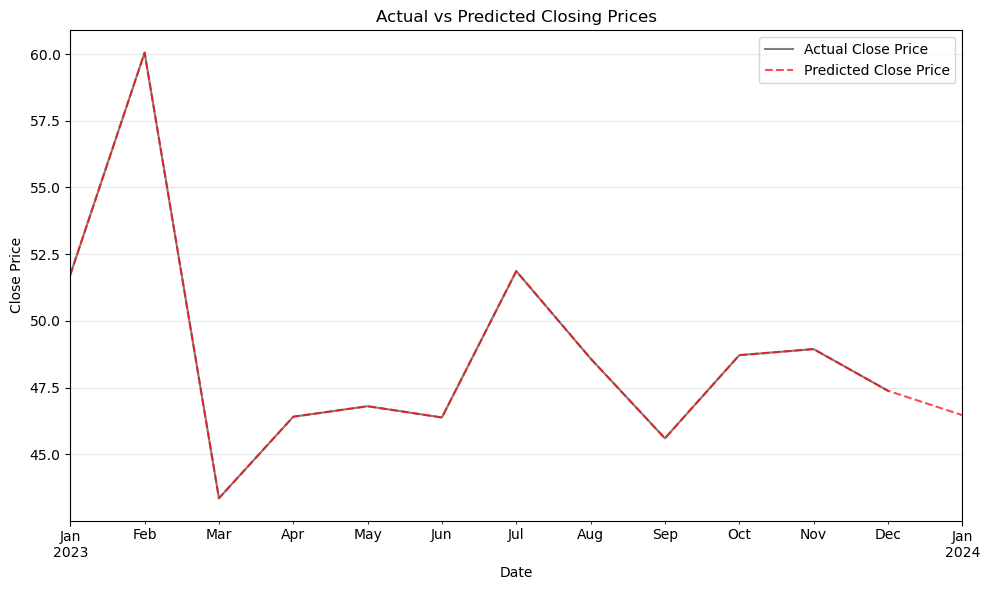

Predicted closing price for the next month: 46.4650062712199


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample data
data = {
    'Date': pd.date_range(start='2023-01-01', periods=365, freq='D'),
    'Close': np.random.rand(365) * 100
}
df = pd.DataFrame(data)

# Resample the data to monthly intervals
df.set_index('Date', inplace=True)
monthly_df = df.resample('M').mean()

# Prepare the data for linear regression
monthly_df['Month'] = np.arange(len(monthly_df))
print(monthly_df.head(5))
X = monthly_df[['Month']]
y = monthly_df['Close']

# Train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions for the next month
next_month = np.array([[len(monthly_df)]])
predicted_close = model.predict(next_month)

# Add the prediction to the DataFrame
predicted_df = monthly_df.copy()
predicted_df.loc[predicted_df.index[-1] + pd.DateOffset(months=1)] = [predicted_close[0], len(monthly_df)]

# Plot the actual vs predicted closing prices
fig, ax = plt.subplots(figsize=(10, 6))
monthly_df['Close'].plot(ax=ax, title='Actual vs Predicted Closing Prices', color='k', label='Actual Close Price', alpha=0.5)
predicted_df['Close'].plot(ax=ax, color='r', linestyle='--', label='Predicted Close Price', alpha=0.7)

ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Print the predicted closing price for the next month
print(f"Predicted closing price for the next month: {predicted_close[0]}")

## 3. Risk Management
3.1. Set stop loss (max 7%) and take profit (between 14%-21%) based on risk-reward ratio.


3.2. Calculate position size that adheres to max stop loss and keeps total risk within acceptable boundaries.


3.3. Take leverage into consideration when calculating actual exposure and risk.
## 4. Execute the trade using Kraken REST API
4.1. Set up connection with Kraken API (handle authentication).


4.2. Monitor trade after execution for any trailing stop conditions or adjustments.


4.3. Log trades, including entries, exits, wins, and losses for further analysis. -->

In [34]:
# Step 2: Calculate Entry and Exit Points
anticipated_pct_change = calculate_anticipated_pct_change(ohlcDFs[assetPair])
support_level, resistance_level = calculate_support_resistance(ohlcDFs[assetPair], anticipated_pct_change)

# Step 3: Risk Management
entry_price = ohlcDFs[assetPair]['Close'].iloc[-1]
risk_reward_ratio = 3  # Example risk-reward ratio
stop_loss, take_profit = calculate_risk_management_levels(entry_price, risk_reward_ratio)
total_capital = 10000  # Example total capital
position_size = calculate_position_size(total_capital, entry_price, stop_loss)

# Plot the historical data with support and resistance levels for each symbol in ohlcDFs
fig, axs = plt.subplots(len(ohlcDFs), figsize=(12, 6 * len(ohlcDFs)))
if len(ohlcDFs) == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

for i, (asset_symbol, df) in enumerate(ohlcDFs.items()):
    support_level, resistance_level = calculate_support_resistance(df, anticipated_pct_change)
    
    axs[i].plot(df['Time'], df['Close'], label='Close Price')
    axs[i].axhline(y=support_level, color='g', linestyle='--', label='Support Level')
    axs[i].axhline(y=resistance_level, color='r', linestyle='--', label='Resistance Level')
    axs[i].set_title(f"Price Chart for {asset_symbol}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Price")
    axs[i].legend()

plt.tight_layout()
plt.show()

# Plot risk management levels
plt.figure(figsize=(12, 6))
plt.plot(ohlcDFs[assetPair]['Time'], ohlcDFs[assetPair]['Close'], label='Close Price')
plt.axhline(y=stop_loss, color='r', linestyle='--', label='Stop Loss')
plt.axhline(y=take_profit, color='g', linestyle='--', label='Take Profit')
plt.title(f"Risk Management Levels for {assetPair}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Step 4: Execute the Trade
#trade_response = execute_trade(api_key, private_key, asset_symbol, position_size, entry_price)
#print("Trade executed successfully:", trade_response)   

NameError: name 'assetPair' is not defined